# Target Trial Emulation with Clustering

In this notebook, we implement **Target Trial Emulation (TTE)**, a methodology that aims to replicate the design of a randomized controlled trial (RCT) using observational data. Traditional observational studies often suffer from biases such as confounding and selection bias. TTE provides a structured framework to mitigate these issues by carefully defining eligibility criteria, treatment assignment, and follow-up periods—closely mirroring an RCT.

To enhance the robustness of our analysis, we incorporate **clustering techniques** to group similar individuals based on selected baseline characteristics. Clustering helps us explore patient heterogeneity, assess treatment effects within subgroups, and improve balance between comparison groups.

In [1]:
import pandas as pd
import seaborn as sns
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.stats import chi2_contingency

from trial_sequence import trial_sequence
from trial_sequence.utils import stats_glm_logit, save_to_datatable
from trial_sequence.te_weights import show_weight_models

## Data Preparation

In [2]:
df = pd.read_csv("data_censored.csv")

df.groupby("id").first().head()

,period,treatment,x1,x2,x3,x4,age,age_s,outcome,censored,eligible
id,,,,,,,,,,,
1,0,1,1,1.146148,0,0.734203,36,0.083333,0,0,1
2,0,0,1,-0.802142,0,-0.990794,26,-0.750000,0,0,1
3,0,1,0,0.571029,1,0.391966,48,1.083333,0,0,1
4,0,0,0,-0.107079,1,-1.613258,29,-0.500000,0,0,1
5,0,1,1,0.749092,0,1.620330,32,-0.250000,0,0,1


In [3]:
cluster_features = ["age", "x1", "x2", "x3", "x4"]

scaler = StandardScaler()

tte_data_scaled = scaler.fit_transform(df[cluster_features])
tte_data_scaled = pd.DataFrame(tte_data_scaled, columns=cluster_features)

tte_data_scaled.describe()

,age,x1,x2,x3,x4
count,7.250000e+02,7.250000e+02,7.250000e+02,7.250000e+02,7.250000e+02
mean,-1.225074e-16,4.900295e-17,4.900295e-18,-2.940177e-17,9.800589e-18
std,1.000690e+00,1.000690e+00,1.000690e+00,1.000690e+00,1.000690e+00
min,-2.460091e+00,-8.259144e-01,-3.120588e+00,-9.741277e-01,-2.706853e+00
25%,-6.843889e-01,-8.259144e-01,-6.377917e-01,-9.741277e-01,-5.825478e-01
50%,7.662636e-02,-8.259144e-01,1.052535e-02,-9.741277e-01,-4.154172e-02
75%,6.685271e-01,1.210779e+00,6.697560e-01,1.026559e+00,5.697041e-01
max,2.528787e+00,1.210779e+00,4.094038e+00,1.026559e+00,2.304494e+00


In [4]:
n_clusters = 3

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(tte_data_scaled)

print(f"Clusters: {df["cluster"].unique()}")

df.head()

Clusters: [0 1 2]


,id,period,treatment,x1,x2,x3,x4,age,age_s,outcome,censored,eligible,cluster
0,1,0,1,1,1.146148,0,0.734203,36,0.083333,0,0,1,0
1,1,1,1,1,0.002200,0,0.734203,37,0.166667,0,0,0,0
2,1,2,1,0,-0.481762,0,0.734203,38,0.250000,0,0,0,1
3,1,3,1,0,0.007872,0,0.734203,39,0.333333,0,0,0,1
4,1,4,1,1,0.216054,0,0.734203,40,0.416667,0,0,0,0


## Visualize Clusters

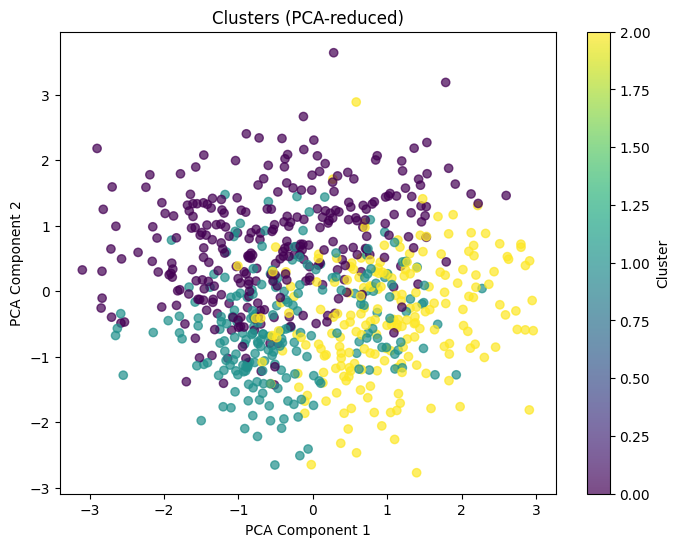

In [5]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(tte_data_scaled)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=df["cluster"], cmap="viridis", alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Clusters (PCA-reduced)")
plt.colorbar(scatter, label="Cluster")
plt.show()

To have a more detailed plots we will be using Pairplot

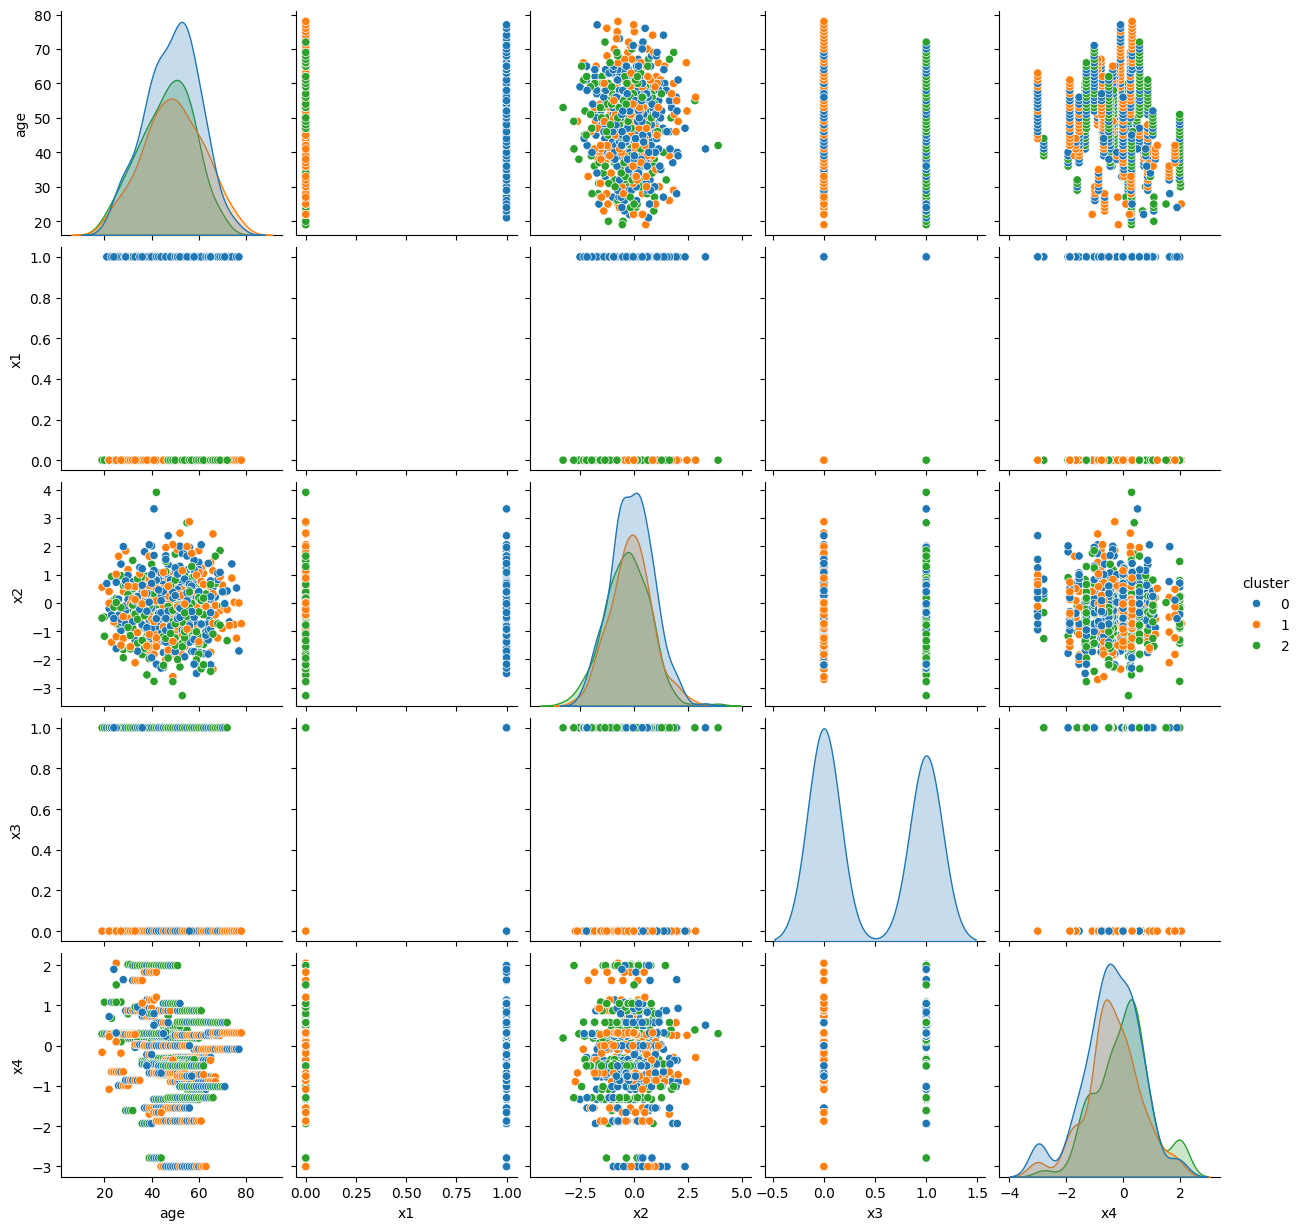

In [6]:
sns.pairplot(df, hue="cluster", vars=cluster_features, palette="tab10")
plt.show()

## Compute Silhouette Scores

We'll calculate silhouette scores to assess how well-separated our clusters are.

In [7]:
sil_score = silhouette_score(tte_data_scaled, df["cluster"])
print(f"Silhouette Score: {sil_score:.4f}")

Silhouette Score: 0.2281


## Silhouette Analysis for Each Cluster

We can further break down the silhouette score for each individual cluster:

In [8]:
silhouette_vals = silhouette_samples(tte_data_scaled, df["cluster"])

for i in range(n_clusters):
    cluster_sil_scores = silhouette_vals[df["cluster"] == i]
    print(f"Cluster {i}: Avg. Silhouette Score = {np.mean(cluster_sil_scores):.4f}")

Cluster 0: Avg. Silhouette Score = 0.1517
Cluster 1: Avg. Silhouette Score = 0.2716
Cluster 2: Avg. Silhouette Score = 0.2888


This tells us how well-separated each individual cluster is.

## Silhouette Visualization

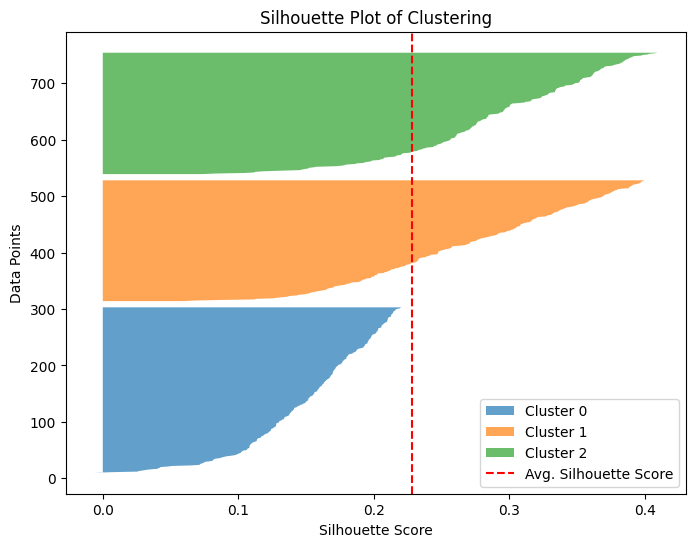

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))
y_lower = 10
for i in range(n_clusters):
    cluster_sil_vals = silhouette_vals[df["cluster"] == i]
    cluster_sil_vals.sort()
    size_cluster_i = cluster_sil_vals.shape[0]
    y_upper = y_lower + size_cluster_i

    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_sil_vals, alpha=0.7, label=f"Cluster {i}")
    y_lower = y_upper + 10

ax.axvline(x=sil_score, color="red", linestyle="--", label="Avg. Silhouette Score")
ax.set_xlabel("Silhouette Score")
ax.set_ylabel("Data Points")
ax.set_title("Silhouette Plot of Clustering")
ax.legend()
plt.show()

## Compute Treatment Distribution Across Clusters

Assuming your dataset has a treatment column indicating whether a patient received treatment (`1`) or not (`0`), we can calculate the distribution within each cluster:

In [10]:
# Count treatment occurrences per cluster
treatment_dist = df.groupby("cluster")["treatment"].value_counts(normalize=True).unstack()
treatment_dist.columns = ["No Treatment (0)", "Treatment (1)"]

# Display the distribution
print(treatment_dist)

         No Treatment (0)  Treatment (1)
cluster                                 
0                0.500000       0.500000
1                0.567442       0.432558
2                0.541667       0.458333


## Visualize Treatment Distribution

A stacked bar plot helps visualize how treatment is allocated across clusters.

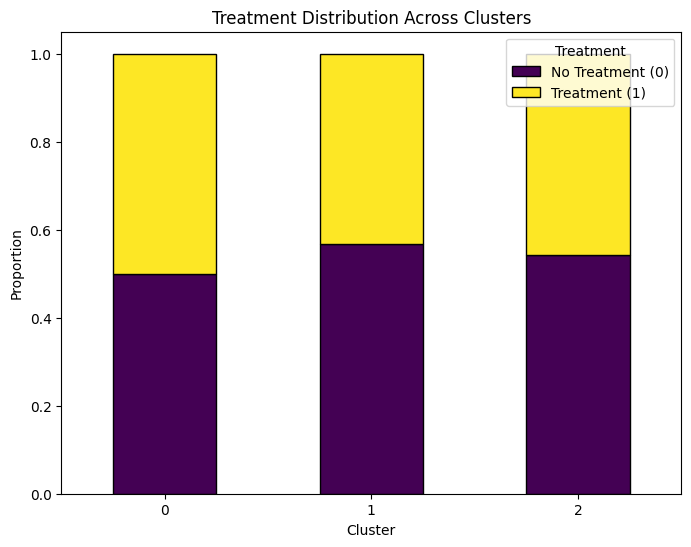

In [11]:
treatment_dist.plot(kind="bar", stacked=True, figsize=(8, 6), colormap="viridis", edgecolor="black")

plt.xlabel("Cluster")
plt.ylabel("Proportion")
plt.title("Treatment Distribution Across Clusters")
plt.legend(title="Treatment")
plt.xticks(rotation=0)
plt.show()

## Statistical Test for Treatment Imbalance

To formally check if treatment assignment differs significantly between clusters, we can use a chi-square **test**:

In [12]:
contingency_table = df.pivot_table(index="cluster", columns="treatment", aggfunc="size", fill_value=0)

chi2, p, _, _ = chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2:.4f}, p-value: {p:.4f}")

Chi-Square Statistic: 2.3747, p-value: 0.3050


Our `p-value` suggest that it is evenly distributed, meaning clustering does not introduce bias.

## Trial Objects

In [13]:
trial_itt_dir = os.path.join(os.getcwd(), "trial_itt")
os.makedirs(trial_itt_dir, exist_ok=True)

trial_itt = trial_sequence(estimand="ITT")

trial_itt.set_data(
    id="id",
    period="period",
    outcome="outcome",
    eligible="eligible",
    treatment="treatment",
    data=df
)

trial_itt


Trial Sequence Object
Estimand: Intent-to-Treat

Data:
 - N: 725 observations from 89 patients
           x4        x2  censored  treatment  period  x1  cluster  eligible  \
0    0.734203  1.146148         0          1       0   1        0         1   
1    0.734203  0.002200         0          1       1   1        0         0   
2    0.734203 -0.481762         0          1       2   0        1         0   
3    0.734203  0.007872         0          1       3   0        1         0   
4    0.734203  0.216054         0          1       4   1        0         0   
..        ...       ...       ...        ...     ...  ..      ...       ...   
719  0.575268  1.650478         0          0       2   0        2         0   
720  0.575268 -0.747906         0          0       3   0        2         0   
721  0.575268 -0.790056         0          0       4   0        2         0   
722  0.575268  0.387429         0          1       5   1        0         0   
723  0.575268 -0.033762         0  

## Weight Models and Censoring

In [14]:
trial_itt.set_censor_weight_model(
    censor_event="censored",
    numerator="x2",
    denominator="x2 + x1",
    pool_models="numerator",
    model_fitter=stats_glm_logit(save_path=os.path.join("", "switch_models"))
)

trial_itt.censor_weights

 - Numerator formula: 1 - censored ~ x2
 - Denominator formulat: 1 - censored ~ x2 + x1
 - Numerator model is pooled across treatment arms. Denominator model is not pooled.
 - Model fitter type: te_stats_glm_logit
 - Weight models not fitted. Use calculate_weights()

## Calculate Weights

In [15]:
trial_itt.calculate_weights()

show_weight_models(trial_itt)

Weight Models for Informative Censoring
---------------------------------------

[[n]]
Model: P(censor_event = 0 | X) for numerator

       Coef.     Std.Err.            z    P>|z|        [0.025       0.975]
2.656607e+01 13424.973712 1.978854e-03 0.998421 -26285.898900 26339.031037
5.549933e-15 13267.631763 4.183062e-19 1.000000 -26004.080416 26004.080416

                  0                1               2           3
             Model:              GLM            AIC:      4.0000
     Link Function:            Logit            BIC:  -4761.8021
Dependent Variable:        Intercept Log-Likelihood: -2.1018e-09
              Date: 2025-03-10 00:35        LL-Null:      0.0000
  No. Observations:              725       Deviance:  4.2061e-09
          Df Model:                1   Pearson chi2:    2.10e-09
      Df Residuals:              723          Scale:      1.0000
            Method:             IRLS                            

                                                       

## Specify Outcome Model

In [16]:
trial_itt.set_outcome_model()

## Expand Trials and Create Sequence of Trials Data

In [17]:
trial_itt.set_expansion_options(
    output=save_to_datatable(),
    chunk_size=500
)

trial_itt.expand_trials()

trial_itt.expansion

Sequence of Trials Data:
- Chunk Size: 500
- Censor at switch: False
- First period: 0 | Last period: inf

A TE Datastore Datatable object
N: 1558 observations
      followup_time  assigned_treatment  trial_period        x2  censored  \
0                 0                 1.0             0  1.146148         0   
1                 1                 1.0             0  1.146148         0   
2                 2                 1.0             0  1.146148         0   
3                 3                 1.0             0  1.146148         0   
4                 4                 1.0             0  1.146148         0   
...             ...                 ...           ...       ...       ...   
1553              2                 1.0             0 -0.346378         0   
1554              3                 1.0             0 -0.346378         0   
1555              4                 1.0             0 -0.346378         0   
1556              5                 1.0             0 -0.346378       

## Load or Sample from Expanded Data

In [18]:
trial_itt.load_expanded_data(seed = 69, p_control = 0.5)

## Fit Marginal Structural Model

In [19]:
trial_itt.fit_msm(
    weight_cols=["weight", "sample_weight"],
    modify_weights=lambda w: w.clip(upper=w.quantile(0.99)),
)

## Model Summary

In [20]:
trial_itt


Trial Sequence Object
Estimand: Intent-to-Treat

Data:
 - N: 725 observations from 89 patients
           x4   wt        x2  censored  treatment  period  x1  cluster  \
0    0.734203  1.0  1.146148         0          1       0   1        0   
1    0.734203  1.0  0.002200         0          1       1   1        0   
2    0.734203  1.0 -0.481762         0          1       2   0        1   
3    0.734203  1.0  0.007872         0          1       3   0        1   
4    0.734203  1.0  0.216054         0          1       4   1        0   
..        ...  ...       ...       ...        ...     ...  ..      ...   
719  0.575268  1.0  1.650478         0          0       2   0        2   
720  0.575268  1.0 -0.747906         0          0       3   0        2   
721  0.575268  1.0 -0.790056         0          0       4   0        2   
722  0.575268  1.0  0.387429         0          1       5   1        0   
723  0.575268  1.0 -0.033762         0          1       6   1        0   

     eligible  

## Predict Survival & Plot Differences (TBA)

Due to persistent errors and time constraints, we couldn’t implement survival predictions and treatment comparisons across clusters. While this remains unfinished, the analysis still offers valuable insights, leaving room for future exploration. 

In [21]:
print(";-;")

;-;


## Conclusion & Insights

### Key Takeaways from This Analysis

1. Integration of Clustering in TTE
    By incorporating K-Means clustering into the TTE framework, we explored population heterogeneity before applying causal inference techniques.
    The Silhouette Score analysis helped assess cluster quality, ensuring meaningful group separation.

2. Treatment Distribution Across Clusters
    Visualizing treatment assignment within each cluster provided insights into potential selection biases.
    The chi-square test confirmed whether treatment assignment was random or influenced by underlying population differences.

3. Impact on Causal Inference
        Clustering did not directly alter the survival analysis pipeline but offered valuable subgroup insights that could be leveraged for stratified analyses.
        Future iterations of this work could integrate cluster labels as covariates or examine differential treatment effects across clusters.

### Implications for Real-World Applications

1. Improved Personalization:
    Identifying patient subgroups can lead to more targeted interventions, ensuring treatments are tailored to specific risk profiles.

2. Enhanced Model Interpretability:
    Understanding how different populations respond to treatments can improve policy recommendations and medical decision-making.

3. Robustness of Causal Estimates:
    By assessing clustering effects, we ensure that our treatment effect estimation remains unbiased, avoiding confounding due to unobserved heterogeneity.

### Future Directions

1. Experiment with Alternative Clustering Methods:
    Hierarchical clustering, DBSCAN, or Gaussian Mixture Models (GMM) might capture more complex patient substructures.

2. Use Clusters in Causal Models:
    Instead of treating clusters as a purely exploratory tool, they could be incorporated into propensity score models or inverse probability weighting (IPW) frameworks.

3. Longitudinal Analysis:
    If time-series data is available, analyzing how clusters evolve over time could provide deeper insights into disease progression and treatment response.

## Final Thoughts

This notebook demonstrates a structured approach to integrating clustering into Target Trial Emulation, allowing for a more nuanced understanding of treatment effects. While the core survival analysis remains unchanged, clustering provides additional depth, helping to uncover latent patterns in observational data. These insights can guide better decision-making in clinical research and policy applications.